In [7]:
import pandas as pd
from pathlib import Path
import numpy as np 
import sys
sys.path.insert(0, "..")   
from src.cluster_util import cluster_data
from src.data_utils import build_feature_and_label_cols, X_FEATURES, Y_FEATURES, WEIGHT_COLUMN
from src.model_utils import create_X_y_dataset
from src.BinaryTriFactorizationEstimator import BinaryTriFactorizationEstimator
from src.BTNMF_util import  get_normalized_assignments, sweep_btf_grid, sweep_btf_grid
from src.BTNMF_util import get_sorted_row_col, pick_best_btf_setting
from src.data_utils import save_csv_or_parquet, normalize_data, build_growth_features_for_clustering, sort_df, load_raw_data
from src.plot_util import plot_block_annot_heatmap


In [2]:
%reload_ext autoreload
%autoreload 2

In [4]:
%pwd

'/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook'

In [17]:
df = pd.read_csv("../data/20250707_train.csv", low_memory=True)
df.head()

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_19955/3711264053.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/20250707_train.csv")


date store_item  store    item   id  unit_sales onpromotion
0  2013-01-01  25_103665     25  103665    0       7.000         NaN
1  2013-01-01  25_819209     25  819209  382       1.788         NaN
2  2013-01-01  25_819231     25  819231  383       1.055         NaN
3  2013-01-01  25_823245     25  823245  384       2.000         NaN
4  2013-01-01  25_827911     25  827911  385       2.000         NaN

In [18]:
df.query("store_item == '10_1000866'")

Empty DataFrame
Columns: [date, store_item, store, item, id, unit_sales, onpromotion]
Index: []

In [1]:
df = pd.read_parquet("../output/data/2014_January_top_53_store_2000_item.parquet")
df.head()

store     item       date  store_item  unit_sales  id onpromotion  weight
0     10  1000866 2014-01-01  10_1000866         NaN NaN        None       1
1     10  1001305 2014-01-01  10_1001305         NaN NaN        None       1
2     10  1003679 2014-01-01  10_1003679         NaN NaN        None       1
3     10  1004545 2014-01-01  10_1004545         NaN NaN        None       1
4     10  1004550 2014-01-01  10_1004550         NaN NaN        None       1

In [2]:
print(df["store"].nunique())
print(df["item"].nunique())

47
2000


In [3]:
df.query("store == 10")

store     item       date  store_item  unit_sales          id  \
0           10  1000866 2014-01-01  10_1000866         NaN         NaN   
1           10  1001305 2014-01-01  10_1001305         NaN         NaN   
2           10  1003679 2014-01-01  10_1003679         NaN         NaN   
3           10  1004545 2014-01-01  10_1004545         NaN         NaN   
4           10  1004550 2014-01-01  10_1004550         NaN         NaN   
...        ...      ...        ...         ...         ...         ...   
2821995     10   996537 2014-01-31   10_996537         NaN         NaN   
2821996     10   996597 2014-01-31   10_996597         NaN         NaN   
2821997     10   996600 2014-01-31   10_996600         NaN         NaN   
2821998     10   996606 2014-01-31   10_996606         NaN         NaN   
2821999     10   999547 2014-01-31   10_999547         1.0  18207567.0   

        onpromotion  weight  
0              None       1  
1              None       1  
2              None       1  
3              None       1  
4              None       1  
...             ...     ...  
2821995        None       1  
2821996        None       1  
2821997        None       1  
2821998        None       1  
2821999        None       1  

[62000 rows x 8 columns]

In [4]:
df.query('store_item == "10_638308"')

store    item       date store_item  unit_sales          id  \
1581        10  638308 2014-01-01  10_638308         NaN         NaN   
95581       10  638308 2014-01-02  10_638308         3.0  16340441.0   
189581      10  638308 2014-01-03  10_638308         NaN         NaN   
283581      10  638308 2014-01-04  10_638308         3.0  16472616.0   
377581      10  638308 2014-01-05  10_638308         NaN         NaN   
471581      10  638308 2014-01-06  10_638308         NaN         NaN   
565581      10  638308 2014-01-07  10_638308         NaN         NaN   
659581      10  638308 2014-01-08  10_638308         1.0  16733800.0   
753581      10  638308 2014-01-09  10_638308         NaN         NaN   
847581      10  638308 2014-01-10  10_638308         1.0  16858796.0   
941581      10  638308 2014-01-11  10_638308         1.0  16922556.0   
1035581     10  638308 2014-01-12  10_638308         1.0  16990439.0   
1129581     10  638308 2014-01-13  10_638308         3.0  17057289.0   
1223581     10  638308 2014-01-14  10_638308         2.0  17120345.0   
1317581     10  638308 2014-01-15  10_638308         4.0  17183151.0   
1411581     10  638308 2014-01-16  10_638308         1.0  17246397.0   
1505581     10  638308 2014-01-17  10_638308         NaN         NaN   
1599581     10  638308 2014-01-18  10_638308         2.0  17374059.0   
1693581     10  638308 2014-01-19  10_638308         3.0  17442391.0   
1787581     10  638308 2014-01-20  10_638308         2.0  17509588.0   
1881581     10  638308 2014-01-21  10_638308         1.0  17573055.0   
1975581     10  638308 2014-01-22  10_638308         1.0  17636547.0   
2069581     10  638308 2014-01-23  10_638308         1.0  17698538.0   
2163581     10  638308 2014-01-24  10_638308         1.0  17760549.0   
2257581     10  638308 2014-01-25  10_638308         1.0  17824341.0   
2351581     10  638308 2014-01-26  10_638308         2.0  17892253.0   
2445581     10  638308 2014-01-27  10_638308         1.0  17958819.0   
2539581     10  638308 2014-01-28  10_638308         NaN         NaN   
2633581     10  638308 2014-01-29  10_638308         1.0  18083891.0   
2727581     10  638308 2014-01-30  10_638308         1.0  18145168.0   
2821581     10  638308 2014-01-31  10_638308         1.0  18207361.0   

        onpromotion  weight  
1581           None       1  
95581          None       1  
189581         None       1  
283581         None       1  
377581         None       1  
471581         None       1  
565581         None       1  
659581         None       1  
753581         None       1  
847581         None       1  
941581         None       1  
1035581        None       1  
1129581        None       1  
1223581        None       1  
1317581        None       1  
1411581        None       1  
1505581        None       1  
1599581        None       1  
1693581        None       1  
1787581        None       1  
1881581        None       1  
1975581        None       1  
2069581        None       1  
2163581        None       1  
2257581        None       1  
2351581        None       1  
2445581        None       1  
2539581        None       1  
2633581        None       1  
2727581        None       1  
2821581        None       1

In [18]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate.parquet")
df = pd.read_parquet(data_path)

In [19]:
df.head()

store     item       date  store_item  unit_sales  id onpromotion  weight  \
0     10  1000866 2014-01-01  10_1000866         NaN NaN        None       1   
1     10  1001305 2014-01-01  10_1001305         NaN NaN        None       1   
2     10  1003679 2014-01-01  10_1003679         NaN NaN        None       1   
3     10  1004545 2014-01-01  10_1004545         NaN NaN        None       1   
4     10  1004550 2014-01-01  10_1004550         NaN NaN        None       1   

    week_end  sales_wk  growth_rate  growth_rate_clipped  growth_binary  \
0 2014-01-05       0.0          NaN                  NaN              0   
1 2014-01-05       0.0          NaN                  NaN              0   
2 2014-01-05      11.0          NaN                  NaN              0   
3 2014-01-05       0.0          NaN                  NaN              0   
4 2014-01-05       7.0          NaN                  NaN              0   

   growth_continuous  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

In [20]:
df.describe()

store          item                           date  \
count  2.914000e+06  2.914000e+06                        2914000   
mean   2.651064e+01  9.564934e+05  2014-01-15 23:59:59.999999488   
min    1.000000e+00  9.699500e+04            2014-01-01 00:00:00   
25%    1.200000e+01  5.709208e+05            2014-01-08 00:00:00   
50%    2.700000e+01  1.005464e+06            2014-01-16 00:00:00   
75%    4.000000e+01  1.370548e+06            2014-01-24 00:00:00   
max    5.400000e+01  1.909755e+06            2014-01-31 00:00:00   
std    1.562850e+01  4.603335e+05                            NaN   

         unit_sales            id     weight             week_end  \
count  1.448386e+06  1.448386e+06  2914000.0              2914000   
mean   1.108910e+01  1.728963e+07        1.0  2014-01-19 00:00:00   
min   -1.700000e+02  1.632266e+07        1.0  2014-01-05 00:00:00   
25%    2.000000e+00  1.680606e+07        1.0  2014-01-12 00:00:00   
50%    5.000000e+00  1.728945e+07        1.0  2014-01-19 00:00:00   
75%    1.100000e+01  1.777326e+07        1.0  2014-01-26 00:00:00   
max    1.000000e+04  1.825650e+07        1.0  2014-02-02 00:00:00   
std    2.445585e+01  5.583088e+05        0.0                  NaN   

           sales_wk   growth_rate  growth_rate_clipped  growth_binary  \
count  2.914000e+06  1.594879e+06         1.594879e+06      2914000.0   
mean   3.512858e+01  2.159711e-01         1.459400e-01       0.261608   
min   -1.700000e+02 -1.710000e+02        -1.000000e+00            0.0   
25%    0.000000e+00 -3.571429e-01        -3.571429e-01            0.0   
50%    8.000000e+00 -3.448276e-02        -3.448276e-02            0.0   
75%    3.300000e+01  3.482910e-01         3.482910e-01            1.0   
max    1.001000e+04  4.540000e+02         5.000000e+00            1.0   
std    9.836082e+01  2.465793e+00         9.248741e-01        0.43951   

       growth_continuous  
count      699451.000000  
mean            0.801563  
min            -1.000000  
25%             0.186147  
50%             0.433962  
75%             1.000000  
max             5.000000  
std             1.039737

In [5]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_weekly_growth_rate.parquet")
df = pd.read_parquet(data_path)

In [6]:
df.head()

store_item       date  sales_wk  growth_rate  growth_rate_clipped  \
0  10_1000866 2014-01-05       0.0          NaN                  NaN   
1  10_1000866 2014-01-12       0.0          NaN                  NaN   
2  10_1000866 2014-01-19       0.0          NaN                  NaN   
3  10_1000866 2014-01-26       0.0          NaN                  NaN   
4  10_1000866 2014-02-02       0.0          NaN                  NaN   

   growth_binary  growth_continuous  direction  growth_up  growth_down  
0              0                NaN          0        NaN          NaN  
1              0                NaN          0        NaN          NaN  
2              0                NaN          0        NaN          NaN  
3              0                NaN          0        NaN          NaN  
4              0                NaN          0        NaN          NaN

In [7]:
df.describe()

date       sales_wk    growth_rate  \
count                         470000  470000.000000  245475.000000   
mean   2014-01-18 23:59:59.999999744      34.172959       0.181611   
min              2014-01-05 00:00:00    -170.000000    -171.000000   
25%              2014-01-12 00:00:00       0.000000      -0.388889   
50%              2014-01-19 00:00:00       8.000000      -0.066901   
75%              2014-01-26 00:00:00      32.000000       0.326083   
max              2014-02-02 00:00:00   10010.000000     454.000000   
std                              NaN      95.931411       2.395417   

       growth_rate_clipped  growth_binary  growth_continuous     direction  \
count        245475.000000       470000.0      102265.000000  470000.00000   
mean              0.114894       0.237687           0.803333      -0.06324   
min              -1.000000            0.0          -1.000000      -1.00000   
25%              -0.388889            0.0           0.186441      -1.00000   
50%              -0.066901            0.0           0.434783       0.00000   
75%               0.326083            0.0           1.000000       0.00000   
max               5.000000            1.0           5.000000       1.00000   
std               0.915263       0.425667           1.042118       0.70173   

           growth_up    growth_down  
count  101798.000000  131521.000000  
mean        0.807089       0.410250  
min         0.010000       0.010000  
25%         0.189296       0.192982  
50%         0.438237       0.363636  
75%         1.000000       0.571429  
max         5.000000       1.000000  
std         1.042979       0.271494

In [13]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate.csv")
save_csv_or_parquet(df, data_path)

2025-09-25 11:45:31,363 - INFO - Saving df to ../output/data/2014_January_top_53_store_2000_item_growth_rate.csv


In [14]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered.parquet")
df = pd.read_parquet(data_path)
df.describe()

store          item                           date  \
count  2.914000e+06  2.914000e+06                        2914000   
mean   2.651064e+01  9.564934e+05  2014-01-16 00:00:00.000000256   
min    1.000000e+00  9.699500e+04            2014-01-01 00:00:00   
25%    1.200000e+01  5.709208e+05            2014-01-08 00:00:00   
50%    2.700000e+01  1.005464e+06            2014-01-16 00:00:00   
75%    4.000000e+01  1.370548e+06            2014-01-24 00:00:00   
max    5.400000e+01  1.909755e+06            2014-01-31 00:00:00   
std    1.562850e+01  4.603335e+05                            NaN   

         unit_sales     weight   growth_rate     block_id  
count  1.448386e+06  2914000.0  1.209524e+06    2896516.0  
mean   1.108910e+01        1.0  4.571560e-01   4258.29525  
min   -1.700000e+02        1.0 -4.000000e+01        878.0  
25%    2.000000e+00        1.0 -4.285714e-01        878.0  
50%    5.000000e+00        1.0  0.000000e+00        878.0  
75%    1.100000e+01        1.0  6.666667e-01       7414.0  
max    1.000000e+04        1.0  5.330000e+02      20025.0  
std    2.445585e+01        0.0  2.147219e+00  5756.312783

In [15]:
df["block_id"].value_counts(dropna=False)

block_id
878      2053564
11620     148025
18178     119846
14148     103664
8830       97278
7414       93527
12228      84940
20025      81530
5846       57753
10723      56389
<NA>       17484
Name: count, dtype: Int64

In [16]:
df["block_id"].nunique()

10

In [17]:
print(df["store"].nunique())
print(df["item"].nunique())

47
2000


In [18]:
df.head()

store     item       date  store_item  unit_sales onpromotion  weight  \
0     10  1000866 2014-01-01  10_1000866         NaN        None       1   
1     10  1000866 2014-01-02  10_1000866         NaN        None       1   
2     10  1000866 2014-01-03  10_1000866         NaN        None       1   
3     10  1000866 2014-01-04  10_1000866         NaN        None       1   
4     10  1000866 2014-01-05  10_1000866         NaN        None       1   

   growth_rate  block_id  
0          NaN     14148  
1          NaN     14148  
2          NaN     14148  
3          NaN     14148  
4          NaN     14148

In [10]:
norm_data = normalize_data(
        df,
        column_name="growth_rate_1",
        log_transform=False,
        median_transform=True,
        mean_transform=False,
        zscore_rows=False,
        zscore_cols=False,
)

2025-09-23 17:05:55,456 - INFO - Finite: 93859, NaNs: 0, 0.0%)


In [12]:

fn = Path("../output/data/growth_rate_2014_January_top_53_store_2000_item_cluster_bt_block_id.npy")
bids = np.load(fn, allow_pickle=True)
bids


array([[12730, 12730, 12730, ..., 12730, 12730, 12730],
       [12730, 10531, 12730, ..., 12730, 12730, 12730],
       [12730, 12730, 12730, ..., 12730, 12730, 20534],
       ...,
       [12730, 12730, 12730, ..., 12730, 12730, 12730],
       [12730, 12730, 12730, ..., 12730, 12730, 12730],
       [12730, 12730, 12730, ..., 11621, 12730, 12730]])

In [13]:
df2 = get_normalized_assignments(bids, norm_data)[
        ["store", "item", "growth_rate_1", "block_id"]
    ]
row_order, col_order = get_sorted_row_col(df2)

In [17]:
df2.head()

store    item  growth_rate_1  block_id
0      1   96995          -62.5     12730
1      1  103501            0.0     12730
2      1  103520            0.0     12730
3      1  103665          -25.0     12730
4      1  105574            0.0     12730

In [19]:
# fn = Path("../output/figures/ train_2014_2015_top_53_store_2000_item_cluster_bt_figure.tiff")
# plot_block_annot_heatmap(
#             df2,
#             ttl="Store-SKU Clusters",
#             value_col="growth_rate_1",
#             block_col="block_id",
#             row_col="store",
#             col_col="item",
#             date_col=None,
#             row_order=row_order,
#             col_order=col_order,
#             fmt="{:.0f}",
#             cell_h=0.6,
#             cell_w=0.75,
#             font_size=11,
#             # figsize=(6, 4),
#             xlabel_size=14,
#             ylabel_size=14,
#             label_weight="bold",
#             fn=fn,
#             show_plot=False,
#     )

In [20]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered_medians.parquet")
df = pd.read_parquet(data_path)
df.describe()

store          item                           date  \
count  2.914000e+06  2.914000e+06                        2914000   
mean   2.651064e+01  9.564934e+05  2014-01-16 00:00:00.000000256   
min    1.000000e+00  9.699500e+04            2014-01-01 00:00:00   
25%    1.200000e+01  5.709208e+05            2014-01-08 00:00:00   
50%    2.700000e+01  1.005464e+06            2014-01-16 00:00:00   
75%    4.000000e+01  1.370548e+06            2014-01-24 00:00:00   
max    5.400000e+01  1.909755e+06            2014-01-31 00:00:00   
std    1.562850e+01  4.603335e+05                            NaN   

         unit_sales     weight   growth_rate     block_id  \
count  1.448386e+06  2914000.0  1.209524e+06    2896516.0   
mean   1.108910e+01        1.0  4.571560e-01   4258.29525   
min   -1.700000e+02        1.0 -4.000000e+01        878.0   
25%    2.000000e+00        1.0 -4.285714e-01        878.0   
50%    5.000000e+00        1.0  0.000000e+00        878.0   
75%    1.100000e+01        1.0  6.666667e-01       7414.0   
max    1.000000e+04        1.0  5.330000e+02      20025.0   
std    2.445585e+01        0.0  2.147219e+00  5756.312783   

       cluster_growth_rate_median  cluster_unit_sales_median  
count                2.868862e+06               2.882689e+06  
mean                 4.117689e-02               4.850772e+00  
min                 -4.937329e-01               2.000000e+00  
25%                 -3.076923e-02               4.000000e+00  
50%                  0.000000e+00               5.000000e+00  
75%                  0.000000e+00               6.000000e+00  
max                  1.666667e+00               9.000000e+00  
std                  3.241750e-01               1.079646e+00

In [21]:
df.head()

store     item       date  store_item  unit_sales onpromotion  weight  \
0     10  1000866 2014-01-01  10_1000866         NaN        None       1   
1     10  1000866 2014-01-02  10_1000866         NaN        None       1   
2     10  1000866 2014-01-03  10_1000866         NaN        None       1   
3     10  1000866 2014-01-04  10_1000866         NaN        None       1   
4     10  1000866 2014-01-05  10_1000866         NaN        None       1   

   growth_rate  block_id  cluster_growth_rate_median  \
0          NaN     14148                   -0.240385   
1          NaN     14148                    1.464286   
2          NaN     14148                   -0.135135   
3          NaN     14148                    0.312500   
4          NaN     14148                    0.000000   

   cluster_unit_sales_median  
0                        3.0  
1                        5.0  
2                        4.0  
3                        6.0  
4                        5.0

In [2]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered_medians_cyc_features.parquet")
df = pd.read_parquet(data_path)
df.describe()

store          item                           date  \
count  2.914000e+06  2.914000e+06                        2914000   
mean   2.651064e+01  9.564934e+05  2014-01-16 00:00:00.000000256   
min    1.000000e+00  9.699500e+04            2014-01-01 00:00:00   
25%    1.200000e+01  5.709208e+05            2014-01-08 00:00:00   
50%    2.700000e+01  1.005464e+06            2014-01-16 00:00:00   
75%    4.000000e+01  1.370548e+06            2014-01-24 00:00:00   
max    5.400000e+01  1.909755e+06            2014-01-31 00:00:00   
std    1.562850e+01  4.603335e+05                            NaN   

         unit_sales     weight   growth_rate     block_id  \
count  1.448386e+06  2914000.0  1.209524e+06    2896516.0   
mean   1.108910e+01        1.0  4.571560e-01   4258.29525   
min   -1.700000e+02        1.0 -4.000000e+01        878.0   
25%    2.000000e+00        1.0 -4.285714e-01        878.0   
50%    5.000000e+00        1.0  0.000000e+00        878.0   
75%    1.100000e+01        1.0  6.666667e-01       7414.0   
max    1.000000e+04        1.0  5.330000e+02      20025.0   
std    2.445585e+01        0.0  2.147219e+00  5756.312783   

       cluster_growth_rate_median  cluster_unit_sales_median     dayofweek  \
count                2.868862e+06               2.882689e+06  2.914000e+06   
mean                 4.117689e-02               4.850772e+00  3.000000e+00   
min                 -4.937329e-01               2.000000e+00  0.000000e+00   
25%                 -3.076923e-02               4.000000e+00  1.000000e+00   
50%                  0.000000e+00               5.000000e+00  3.000000e+00   
75%                  0.000000e+00               6.000000e+00  5.000000e+00   
max                  1.666667e+00               9.000000e+00  6.000000e+00   
std                  3.241750e-01               1.079646e+00  1.917660e+00   

       ...  unit_sales_rolling_median  unit_sales_ewm_decay  \
count  ...               1.830460e+06          1.899451e+06   
mean   ...               9.099030e+00          9.661850e+00   
min    ...              -1.700000e+02         -9.366128e+01   
25%    ...               2.000000e+00          2.171194e+00   
50%    ...               4.000000e+00          4.280715e+00   
75%    ...               9.000000e+00          9.682053e+00   
max    ...               1.000000e+04          3.724657e+03   
std    ...               2.278564e+01          2.310683e+01   

       growth_rate_rolling_median  growth_rate_ewm_decay  unit_sales_arima  \
count                1.602729e+06           1.712463e+06      12057.000000   
mean                 1.466364e-01           4.468692e-01         14.270120   
min                 -1.700000e+01          -1.018415e+01        -21.256668   
25%                 -1.666667e-01           1.232215e-02          5.416446   
50%                  0.000000e+00           2.445312e-01          8.948954   
75%                  2.500000e-01           6.007199e-01         16.147950   
max                  1.201012e+02           1.336610e+02        310.723382   
std                  9.019691e-01           1.079931e+00         17.969696   

       growth_rate_arima  unit_sales_block  bid_unit_sales_arima  \
count        7082.000000      2.896516e+06          2.242464e+06   
mean            0.634693      2.639271e+05          2.709278e+05   
min           -43.591951      0.000000e+00          8.104623e+03   
25%             0.255799      2.331165e+04          2.552593e+04   
50%             0.596665      3.184287e+05          3.629811e+05   
75%             1.053398      3.827345e+05          3.825290e+05   
max             9.035321      5.768639e+05          4.278127e+05   
std             1.282762      1.827821e+05          1.632064e+05   

       growth_rate_block  bid_growth_rate_arima  
count       2.896516e+06           2.242464e+06  
mean        3.083731e+00           6.123081e+00  
min        -4.621138e-01          -3.842248e-01  
25%        -1.255574e-01           2.280407e+00  
50%         2.

In [3]:
df.columns

Index(['store', 'item', 'date', 'store_item', 'unit_sales', 'onpromotion',
       'weight', 'growth_rate', 'block_id', 'cluster_growth_rate_median',
       'cluster_unit_sales_median', 'dayofweek', 'weekofmonth', 'monthofyear',
       'dayofweek_sin', 'dayofweek_cos', 'weekofmonth_sin', 'weekofmonth_cos',
       'monthofyear_sin', 'monthofyear_cos', 'paycycle_sin', 'paycycle_cos',
       'season_sin', 'season_cos', 'unit_sales_rolling_median',
       'unit_sales_ewm_decay', 'growth_rate_rolling_median',
       'growth_rate_ewm_decay', 'unit_sales_arima', 'growth_rate_arima',
       'unit_sales_block', 'bid_unit_sales_arima', 'growth_rate_block',
       'bid_growth_rate_arima'],
      dtype='object')

In [32]:
df[['store', 'item', 'date', 'store_item', 'unit_sales', 'unit_sales_rolling_median', 'unit_sales_ewm_decay']].describe()

store          item                           date  \
count  2.914000e+06  2.914000e+06                        2914000   
mean   2.651064e+01  9.564934e+05  2014-01-16 00:00:00.000000256   
min    1.000000e+00  9.699500e+04            2014-01-01 00:00:00   
25%    1.200000e+01  5.709208e+05            2014-01-08 00:00:00   
50%    2.700000e+01  1.005464e+06            2014-01-16 00:00:00   
75%    4.000000e+01  1.370548e+06            2014-01-24 00:00:00   
max    5.400000e+01  1.909755e+06            2014-01-31 00:00:00   
std    1.562850e+01  4.603335e+05                            NaN   

         unit_sales  unit_sales_rolling_median  unit_sales_ewm_decay  
count  1.448386e+06               1.830460e+06          1.899451e+06  
mean   1.108910e+01               9.099030e+00          9.661850e+00  
min   -1.700000e+02              -1.700000e+02         -9.366128e+01  
25%    2.000000e+00               2.000000e+00          2.171194e+00  
50%    5.000000e+00               4.000000e+00          4.280715e+00  
75%    1.100000e+01               9.000000e+00          9.682053e+00  
max    1.000000e+04               1.000000e+04          3.724657e+03  
std    2.445585e+01               2.278564e+01          2.310683e+01

In [34]:
df[['store', 'item', 'date', 'store_item', 'unit_sales', 'unit_sales_arima', 'growth_rate_arima']].describe()

store          item                           date  \
count  2.914000e+06  2.914000e+06                        2914000   
mean   2.651064e+01  9.564934e+05  2014-01-16 00:00:00.000000256   
min    1.000000e+00  9.699500e+04            2014-01-01 00:00:00   
25%    1.200000e+01  5.709208e+05            2014-01-08 00:00:00   
50%    2.700000e+01  1.005464e+06            2014-01-16 00:00:00   
75%    4.000000e+01  1.370548e+06            2014-01-24 00:00:00   
max    5.400000e+01  1.909755e+06            2014-01-31 00:00:00   
std    1.562850e+01  4.603335e+05                            NaN   

         unit_sales  unit_sales_arima  growth_rate_arima  
count  1.448386e+06      12057.000000        7082.000000  
mean   1.108910e+01         14.270120           0.634693  
min   -1.700000e+02        -21.256668         -43.591951  
25%    2.000000e+00          5.416446           0.255799  
50%    5.000000e+00          8.948954           0.596665  
75%    1.100000e+01         16.147950           1.053398  
max    1.000000e+04        310.723382           9.035321  
std    2.445585e+01         17.969696           1.282762

In [35]:
df[['store', 'item', 'date', 'store_item', 'unit_sales', 'unit_sales_block', 'bid_unit_sales_arima', 'growth_rate_block',
       'bid_growth_rate_arima']].describe()

store          item                           date  \
count  2.914000e+06  2.914000e+06                        2914000   
mean   2.651064e+01  9.564934e+05  2014-01-16 00:00:00.000000256   
min    1.000000e+00  9.699500e+04            2014-01-01 00:00:00   
25%    1.200000e+01  5.709208e+05            2014-01-08 00:00:00   
50%    2.700000e+01  1.005464e+06            2014-01-16 00:00:00   
75%    4.000000e+01  1.370548e+06            2014-01-24 00:00:00   
max    5.400000e+01  1.909755e+06            2014-01-31 00:00:00   
std    1.562850e+01  4.603335e+05                            NaN   

         unit_sales  unit_sales_block  bid_unit_sales_arima  \
count  1.448386e+06      2.896516e+06          2.242464e+06   
mean   1.108910e+01      2.639271e+05          2.709278e+05   
min   -1.700000e+02      0.000000e+00          8.104623e+03   
25%    2.000000e+00      2.331165e+04          2.552593e+04   
50%    5.000000e+00      3.184287e+05          3.629811e+05   
75%    1.100000e+01      3.827345e+05          3.825290e+05   
max    1.000000e+04      5.768639e+05          4.278127e+05   
std    2.445585e+01      1.827821e+05          1.632064e+05   

       growth_rate_block  bid_growth_rate_arima  
count       2.896516e+06           2.242464e+06  
mean        3.083731e+00           6.123081e+00  
min        -4.621138e-01          -3.842248e-01  
25%        -1.255574e-01           2.280407e+00  
50%         2.351443e-02           5.593755e+00  
75%         1.318603e-01           8.046167e+00  
max         1.279835e+02           1.765537e+01  
std         1.923827e+01           4.598618e+00

In [32]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered_medians_cyc_features.parquet")
df = pd.read_parquet(data_path)
df.describe()

store          item                           date  \
count  2.914000e+06  2.914000e+06                        2914000   
mean   2.651064e+01  9.564934e+05  2014-01-16 00:00:00.000000256   
min    1.000000e+00  9.699500e+04            2014-01-01 00:00:00   
25%    1.200000e+01  5.709208e+05            2014-01-08 00:00:00   
50%    2.700000e+01  1.005464e+06            2014-01-16 00:00:00   
75%    4.000000e+01  1.370548e+06            2014-01-24 00:00:00   
max    5.400000e+01  1.909755e+06            2014-01-31 00:00:00   
std    1.562850e+01  4.603335e+05                            NaN   

         unit_sales     weight   growth_rate     block_id  \
count  1.448386e+06  2914000.0  1.209524e+06    2896516.0   
mean   1.108910e+01        1.0  4.571560e-01   4258.29525   
min   -1.700000e+02        1.0 -4.000000e+01        878.0   
25%    2.000000e+00        1.0 -4.285714e-01        878.0   
50%    5.000000e+00        1.0  0.000000e+00        878.0   
75%    1.100000e+01        1.0  6.666667e-01       7414.0   
max    1.000000e+04        1.0  5.330000e+02      20025.0   
std    2.445585e+01        0.0  2.147219e+00  5756.312783   

       cluster_growth_rate_median  cluster_unit_sales_median     dayofweek  \
count                2.868862e+06               2.882689e+06  2.914000e+06   
mean                 4.117689e-02               4.850772e+00  3.000000e+00   
min                 -4.937329e-01               2.000000e+00  0.000000e+00   
25%                 -3.076923e-02               4.000000e+00  1.000000e+00   
50%                  0.000000e+00               5.000000e+00  3.000000e+00   
75%                  0.000000e+00               6.000000e+00  5.000000e+00   
max                  1.666667e+00               9.000000e+00  6.000000e+00   
std                  3.241750e-01               1.079646e+00  1.917660e+00   

       ...  unit_sales_rolling_median  unit_sales_ewm_decay  \
count  ...               1.830460e+06          1.899451e+06   
mean   ...               9.099030e+00          9.661850e+00   
min    ...              -1.700000e+02         -9.366128e+01   
25%    ...               2.000000e+00          2.171194e+00   
50%    ...               4.000000e+00          4.280715e+00   
75%    ...               9.000000e+00          9.682053e+00   
max    ...               1.000000e+04          3.724657e+03   
std    ...               2.278564e+01          2.310683e+01   

       growth_rate_rolling_median  growth_rate_ewm_decay  unit_sales_arima  \
count                1.602729e+06           1.712463e+06      12057.000000   
mean                 1.466364e-01           4.468692e-01         14.270120   
min                 -1.700000e+01          -1.018415e+01        -21.256668   
25%                 -1.666667e-01           1.232215e-02          5.416446   
50%                  0.000000e+00           2.445312e-01          8.948954   
75%                  2.500000e-01           6.007199e-01         16.147950   
max                  1.201012e+02           1.336610e+02        310.723382   
std                  9.019691e-01           1.079931e+00         17.969696   

       growth_rate_arima  unit_sales_block  bid_unit_sales_arima  \
count        7082.000000      2.896516e+06          2.242464e+06   
mean            0.634693      2.639271e+05          2.709278e+05   
min           -43.591951      0.000000e+00          8.104623e+03   
25%             0.255799      2.331165e+04          2.552593e+04   
50%             0.596665      3.184287e+05          3.629811e+05   
75%             1.053398      3.827345e+05          3.825290e+05   
max             9.035321      5.768639e+05          4.278127e+05   
std             1.282762      1.827821e+05          1.632064e+05   

       growth_rate_block  bid_growth_rate_arima  
count       2.896516e+06           2.242464e+06  
mean        3.083731e+00           6.123081e+00  
min        -4.621138e-01          -3.842248e-01  
25%        -1.255574e-01           2.280407e+00  
50%         2.

In [33]:
df.columns

Index(['store', 'item', 'date', 'store_item', 'unit_sales', 'onpromotion',
       'weight', 'growth_rate', 'block_id', 'cluster_growth_rate_median',
       'cluster_unit_sales_median', 'dayofweek', 'weekofmonth', 'monthofyear',
       'dayofweek_sin', 'dayofweek_cos', 'weekofmonth_sin', 'weekofmonth_cos',
       'monthofyear_sin', 'monthofyear_cos', 'paycycle_sin', 'paycycle_cos',
       'season_sin', 'season_cos', 'unit_sales_rolling_median',
       'unit_sales_ewm_decay', 'growth_rate_rolling_median',
       'growth_rate_ewm_decay', 'unit_sales_arima', 'growth_rate_arima',
       'unit_sales_block', 'bid_unit_sales_arima', 'growth_rate_block',
       'bid_growth_rate_arima'],
      dtype='object')

In [5]:

data_path = Path("../output/data/2014_January_top_53_store_2000_item_weekly_growth_rate.parquet")
df = pd.read_parquet(data_path)
df.head()

store_item       date  sales_wk  growth_rate  growth_rate_clipped  \
0  10_1000866 2014-01-05       0.0          NaN                  NaN   
1  10_1000866 2014-01-12       0.0          NaN                  NaN   
2  10_1000866 2014-01-19       0.0          NaN                  NaN   
3  10_1000866 2014-01-26       0.0          NaN                  NaN   
4  10_1000866 2014-02-02       0.0          NaN                  NaN   

   growth_binary  growth_continuous  direction  growth_up  growth_down  
0              0                NaN          0        NaN          NaN  
1              0                NaN          0        NaN          NaN  
2              0                NaN          0        NaN          NaN  
3              0                NaN          0        NaN          NaN  
4              0                NaN          0        NaN          NaN

In [6]:
df.describe()

date       sales_wk    growth_rate  \
count                         470000  470000.000000  245475.000000   
mean   2014-01-18 23:59:59.999999744      34.172959       0.181611   
min              2014-01-05 00:00:00    -170.000000    -171.000000   
25%              2014-01-12 00:00:00       0.000000      -0.388889   
50%              2014-01-19 00:00:00       8.000000      -0.066901   
75%              2014-01-26 00:00:00      32.000000       0.326083   
max              2014-02-02 00:00:00   10010.000000     454.000000   
std                              NaN      95.931411       2.395417   

       growth_rate_clipped  growth_binary  growth_continuous     direction  \
count        245475.000000       470000.0      102265.000000  470000.00000   
mean              0.114894       0.237687           0.803333      -0.06324   
min              -1.000000            0.0          -1.000000      -1.00000   
25%              -0.388889            0.0           0.186441      -1.00000   
50%              -0.066901            0.0           0.434783       0.00000   
75%               0.326083            0.0           1.000000       0.00000   
max               5.000000            1.0           5.000000       1.00000   
std               0.915263       0.425667           1.042118       0.70173   

           growth_up    growth_down  
count  101798.000000  131521.000000  
mean        0.807089       0.410250  
min         0.010000       0.010000  
25%         0.189296       0.192982  
50%         0.438237       0.363636  
75%         1.000000       0.571429  
max         5.000000       1.000000  
std         1.042979       0.271494

In [21]:

data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_input_clustered.parquet")
df = pd.read_parquet(data_path)
df.head(10)

store_item   gc_mean  gc_median    gc_std    gc_iqr   gr_mean    gr_std  \
0  10_1000866  0.254694   0.250927  0.070478  0.017176  0.170819  0.125976   
1  10_1001305  0.254694   0.250927  0.070478  0.017176  0.170819  0.125976   
2  10_1003679  0.266667   0.266667  0.070478  0.000000  0.179694  0.082164   
3  10_1004545  0.254694   0.250927  0.070478  0.017176  0.170819  0.125976   
4  10_1004550  0.625000   0.625000  0.750000  0.566819  0.330357  0.647452   
5  10_1004551  0.250000   0.250000  0.070478  0.000000  0.173611  0.080985   
6  10_1005456  0.254694   0.250927  0.070478  0.017176  0.170819  0.125976   
7  10_1005458  0.254694   0.250927  0.070478  0.017176  0.170819  0.125976   
8  10_1005461  0.254694   0.250927  0.070478  0.017176  0.170819  0.125976   
9  10_1005463  0.254694   0.250927  0.070478  0.017176  0.170819  0.125976   

     gr_iqr  frac_nonzero  frac_up  frac_down  pos_to_neg_ratio  \
0  0.085204           0.0     0.00       0.00          0.333333   
1  0.085204           0.0     0.00       0.00          0.333333   
2  0.032987           1.0     0.25       0.75          0.111111   
3  0.085204           0.0     0.00       0.00          0.333333   
4  0.400000           1.0     0.50       0.50          0.333333   
5  0.035088           0.5     0.25       0.25          0.333333   
6  0.085204           0.0     0.00       0.00          0.333333   
7  0.085204           0.0     0.00       0.00          0.333333   
8  0.085204           0.0     0.00       0.00          0.333333   
9  0.085204           0.0     0.00       0.00          0.333333   

   big_move_rate   ac_lag1   ac_lag4  median_up  median_down_mag  \
0            0.0  0.737319  0.267949   0.100032         0.374620   
1            0.0  0.737319  0.267949   0.100032         0.374620   
2            0.5  0.101388  0.267949   0.118200         0.080743   
3            0.0  0.737319  0.267949   0.100032         0.374620   
4            1.0  0.050326  0.267949   0.549080         0.783318   
5            0.5  0.218189  0.267949   0.098160         0.325878   
6            0.0  0.737319  0.267949   0.100032         0.374620   
7            0.0  0.737319  0.267949   0.100032         0.374620   
8            0.0  0.737319  0.267949   0.100032         0.374620   
9            0.0  0.737319  0.267949   0.100032         0.374620   

   robust_support_n  robust_has_variance  robust_supported  
0               0.0                  0.0               0.0  
1               0.0                  0.0               0.0  
2               1.0                  1.0               0.0  
3               0.0                  0.0               0.0  
4               1.0                  1.0               0.0  
5               1.0                  1.0               0.0  
6               0.0                  0.0               0.0  
7               0.0                  0.0               0.0  
8               0.0                  0.0               0.0  
9               0.0                  0.0               0.0

In [24]:
if "robust_" in df.columns.to_list():
            df.drop(
                columns=[c for c in df.columns if c.startswith("robust_")],
                errors="ignore",
                inplace=True,
            )

In [26]:
"robust_" in df.columns.to_list()

False

In [27]:
df.columns.to_list()

['store_item',
 'gc_mean',
 'gc_median',
 'gc_std',
 'gc_iqr',
 'gr_mean',
 'gr_std',
 'gr_iqr',
 'frac_nonzero',
 'frac_up',
 'frac_down',
 'pos_to_neg_ratio',
 'big_move_rate',
 'ac_lag1',
 'ac_lag4',
 'median_up',
 'median_down_mag',
 'robust_support_n',
 'robust_has_variance',
 'robust_supported']

In [25]:
df.columns

Index(['store_item', 'gc_mean', 'gc_median', 'gc_std', 'gc_iqr', 'gr_mean',
       'gr_std', 'gr_iqr', 'frac_nonzero', 'frac_up', 'frac_down',
       'pos_to_neg_ratio', 'big_move_rate', 'ac_lag1', 'ac_lag4', 'median_up',
       'median_down_mag', 'robust_support_n', 'robust_has_variance',
       'robust_supported'],
      dtype='object')

In [19]:
df[['robust_support_n', 'robust_has_variance',
       'robust_supported']].describe()

robust_support_n  robust_has_variance  robust_supported
count      94000.000000         94000.000000           94000.0
mean           0.652859             0.672926               0.0
std            0.451739             0.469147               0.0
min            0.000000             0.000000               0.0
25%            0.000000             0.000000               0.0
50%            1.000000             1.000000               0.0
75%            1.000000             1.000000               0.0
max            1.000000             1.000000               0.0

In [13]:
df[['store_item', 'gc_mean', 'gc_median', 'gc_std', 'gc_iqr', 'gr_mean',
       'gr_std', 'gr_iqr', 'frac_nonzero', 'frac_up', 'frac_down',
       'pos_to_neg_ratio', 'big_move_rate', 'ac_lag1', 'ac_lag4', 'ac_lag12',
       'trend_slope', 'seasonal_strength']].describe()

gc_mean     gc_median        gc_std        gc_iqr       gr_mean  \
count  94000.000000  94000.000000  94000.000000  94000.000000  94000.000000   
mean       0.291571      0.288403      0.094350      0.046887      0.178326   
std        0.131965      0.132330      0.108301      0.094105      0.062877   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.235772      0.233333      0.070478      0.000364      0.160082   
50%        0.254694      0.250927      0.070478      0.017176      0.170819   
75%        0.281739      0.277778      0.070478      0.036268      0.185162   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             gr_std        gr_iqr  frac_nonzero       frac_up     frac_down  \
count  94000.000000  94000.000000  94000.000000  94000.000000  94000.000000   
mean       0.161083      0.106724      0.592048      0.256912      0.335136   
std        0.127461      0.085962      0.426080      0.233987      0.265239   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.101899      0.065904      0.000000      0.000000      0.000000   
50%        0.125976      0.085204      0.750000      0.250000      0.500000   
75%        0.159537      0.113027      1.000000      0.500000      0.500000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       pos_to_neg_ratio  big_move_rate       ac_lag1  ac_lag4  ac_lag12  \
count      94000.000000    94000.00000  94000.000000      0.0       0.0   
mean           0.317595        0.54621      0.367226      NaN       NaN   
std            0.211913        0.40409      0.256358      NaN       NaN   
min            0.000000        0.00000      0.000000      NaN       NaN   
25%            0.166667        0.00000      0.250939      NaN       NaN   
50%            0.333333        0.75000      0.306692      NaN       NaN   
75%            0.333333        1.00000      0.393240      NaN       NaN   
max            1.000000        1.00000      1.000000      NaN       NaN   

       trend_slope  seasonal_strength  
count          0.0                0.0  
mean           NaN                NaN  
std            NaN                NaN  
min            NaN                NaN  
25%            NaN                NaN  
50%            NaN                NaN  
75%            NaN                NaN  
max            NaN                NaN

In [14]:
df[['gr_median_nz',
       'gr_trimmed_mean_10_90', 'gr_huber_mean_q01_q99', 'gr_median_abs',
       'gr_share_zero', 'median_up', 'median_down_mag']].describe()

gr_median_nz  gr_trimmed_mean_10_90  gr_huber_mean_q01_q99  \
count  94000.000000           94000.000000           94000.000000   
mean       0.156536               0.158494               0.177773   
std        0.062446               0.050434               0.062251   
min        0.000000               0.000000               0.000000   
25%        0.141204               0.150000               0.159943   
50%        0.154762               0.159097               0.170548   
75%        0.169686               0.166994               0.184611   
max        1.000000               1.000000               1.000000   

       gr_median_abs  gr_share_zero     median_up  median_down_mag  
count   94000.000000   94000.000000  94000.000000     94000.000000  
mean        0.086231       0.060811      0.144922         0.413118  
std         0.058289       0.126910      0.159058         0.206154  
min         0.000000       0.000000      0.000000         0.000000  
25%         0.058398       0.000000      0.078119         0.303407  
50%         0.073794       0.000000      0.100032         0.374620  
75%         0.094098       0.000000      0.131561         0.467799  
max         1.000000       1.000000      1.000000         1.000000

In [15]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_features.parquet")
df = pd.read_parquet(data_path)
df.head()

store_item  gc_mean  gc_median    gc_std  gc_iqr   gr_mean    gr_std  \
0  10_1000866      NaN        NaN       NaN     NaN       NaN       NaN   
1  10_1001305      NaN        NaN       NaN     NaN       NaN       NaN   
2  10_1003679     0.60       0.60       NaN    0.00  0.078166  0.348593   
3  10_1004545      NaN        NaN       NaN     NaN       NaN       NaN   
4  10_1004550     2.75       2.75  3.181981    2.25  0.982143  2.746906   

    gr_iqr  frac_nonzero  frac_up  ...  ac_lag12  trend_slope  \
0      NaN           0.0      0.0  ...       NaN          NaN   
1      NaN           0.0      0.0  ...       NaN          NaN   
2  0.19586           0.8      0.2  ...       NaN          NaN   
3      NaN           0.0      0.0  ...       NaN          NaN   
4  2.37500           0.8      0.4  ...       NaN          NaN   

   seasonal_strength  gr_median_nz  gr_trimmed_mean_10_90  \
0                NaN           NaN                    NaN   
1                NaN           NaN                    NaN   
2                NaN     -0.081169              -0.081169   
3                NaN           NaN                    NaN   
4                NaN     -0.107143              -0.107143   

   gr_huber_mean_q01_q99  gr_median_abs  gr_share_zero  median_up  \
0                    NaN            NaN            0.0        NaN   
1                    NaN            NaN            0.0        NaN   
2               0.073386       0.107955            0.0       0.60   
3                    NaN            NaN            0.0        NaN   
4               0.949464       0.785714            0.0       2.75   

   median_down_mag  
0              NaN  
1              NaN  
2         0.090909  
3              NaN  
4         0.785714  

[5 rows x 25 columns]

In [8]:
build_growth_features_for_clustering(df)

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/data_utils.py:684: RuntimeWarning: Mean of empty slice
  huber_mean_q01_q99 = np.nanmean(huberized)
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/data_utils.py:684: RuntimeWarning: Mean of empty slice
  huber_mean_q01_q99 = np.nanmean(huberized)
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/data_utils.py:684: RuntimeWarning: Mean of empty slice
  huber_mean_q01_q99 = np.nanmean(huberized)
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/data_utils.py:684: RuntimeWarning: Mean of empty slice
  huber_mean_q01_q99 = np.nanmean(huberized)
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/da

(       store_item   gc_mean  gc_median    gc_std    gc_iqr   gr_mean  \
 0      10_1000866  0.254694   0.250927  0.070478  0.017176  0.170819   
 1      10_1001305  0.254694   0.250927  0.070478  0.017176  0.170819   
 2      10_1003679  0.266667   0.266667  0.070478  0.000000  0.179694   
 3      10_1004545  0.254694   0.250927  0.070478  0.017176  0.170819   
 4      10_1004550  0.625000   0.625000  0.750000  0.566819  0.330357   
 ...           ...       ...        ...       ...       ...       ...   
 93995    9_996537  0.266958   0.266958  0.191574  0.144784  0.163587   
 93996    9_996597  1.000000   1.000000  0.070478  0.000000  0.297454   
 93997    9_996600  0.238095   0.238095  0.047619  0.035988  0.159031   
 93998    9_996606  0.254694   0.250927  0.070478  0.017176  0.170819   
 93999    9_999547  0.171795   0.171795  0.070478  0.000000  0.140776   
 
          gr_std    gr_iqr  frac_nonzero  frac_up  ...  ac_lag12  trend_slope  \
 0      0.125976  0.085204           0.0 

In [3]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered_medians_cyc_X_y_features.parquet")
df = pd.read_parquet(data_path)

In [4]:
df.head(10)

store     item       date  store_item  unit_sales onpromotion  weight  \
806062     25  1003679 2014-01-01  25_1003679       3.000        None       1   
806124     25  1004550 2014-01-01  25_1004550      36.000        None       1   
806155     25  1004551 2014-01-01  25_1004551      20.000        None       1   
806496     25  1009998 2014-01-01  25_1009998       2.000        None       1   
806651     25  1014865 2014-01-01  25_1014865       7.000        None       1   
806775     25  1018878 2014-01-01  25_1018878       9.000        None       1   
806899     25  1022053 2014-01-01  25_1022053       1.000        None       1   
806992     25  1028589 2014-01-01  25_1028589      27.000        None       1   
807085     25  1036189 2014-01-01  25_1036189       1.833        None       1   
807178     25   103665 2014-01-01   25_103665       4.000        None       1   

        growth_rate  block_id  cluster_growth_rate_median  ...  \
806062          NaN     14148                   -0.240385  ...   
806124     35.00000     14148                   -0.240385  ...   
806155     -0.62963      8830                    0.000000  ...   
806496     -0.60000       878                   -0.444444  ...   
806651          NaN       878                   -0.444444  ...   
806775      3.50000     14148                   -0.240385  ...   
806899      0.00000     14148                   -0.240385  ...   
806992          NaN       878                   -0.444444  ...   
807085          NaN     14148                   -0.240385  ...   
807178          NaN       878                   -0.444444  ...   

        growth_rate_arima  unit_sales_block  bid_unit_sales_arima  \
806062                NaN       1060.069802                   NaN   
806124                NaN       1060.069802                   NaN   
806155                NaN       1122.462498                   NaN   
806496                NaN       3726.517003                   NaN   
806651                NaN       3726.517003                   NaN   
806775                NaN       1060.069802                   NaN   
806899                NaN       1060.069802                   NaN   
806992                NaN       3726.517003                   NaN   
807085                NaN       1060.069802                   NaN   
807178                NaN       3726.517003                   NaN   

        growth_rate_block  bid_growth_rate_arima         y  \
806062                0.0                    NaN  0.000000   
806124                0.0                    NaN -0.361111   
806155                0.0                    NaN  0.800000   
806496                0.0                    NaN  1.000000   
806651                0.0                    NaN -0.285714   
806775                0.0                    NaN -0.444444   
806899                0.0                    NaN  2.000000   
806992                0.0                    NaN -0.666667   
807085                0.0                    NaN -0.539553   
807178                0.0                    NaN -0.500000   

        unit_sales_arima_tplus1  growth_rate_arima_tplus1  \
806062                      NaN                       NaN   
806124                      NaN                       NaN   
806155                      NaN                       NaN   
806496                      NaN                       NaN   
806651                      NaN                       NaN   
806775                      NaN                       NaN   
806899                      NaN                       NaN   
806992                      NaN                       NaN   
807085                      NaN                       NaN   
807178                      NaN                       NaN   

        bid_unit_sales_arima_tplus1  bid_growth_rate_arima_tplus1  
806062                          NaN                           NaN  
806124                          NaN                           NaN  
806155                          NaN                           NaN  
80

In [6]:
df.columns

Index(['store', 'item', 'date', 'store_item', 'unit_sales', 'onpromotion',
       'weight', 'growth_rate', 'block_id', 'cluster_growth_rate_median',
       'cluster_unit_sales_median', 'dayofweek', 'weekofmonth', 'monthofyear',
       'dayofweek_sin', 'dayofweek_cos', 'weekofmonth_sin', 'weekofmonth_cos',
       'monthofyear_sin', 'monthofyear_cos', 'paycycle_sin', 'paycycle_cos',
       'season_sin', 'season_cos', 'unit_sales_rolling_median',
       'unit_sales_ewm_decay', 'growth_rate_rolling_median',
       'growth_rate_ewm_decay', 'unit_sales_arima', 'growth_rate_arima',
       'unit_sales_block', 'bid_unit_sales_arima', 'growth_rate_block',
       'bid_growth_rate_arima', 'y', 'unit_sales_arima_tplus1',
       'growth_rate_arima_tplus1', 'bid_unit_sales_arima_tplus1',
       'bid_growth_rate_arima_tplus1'],
      dtype='object')

In [11]:
ok = df.groupby("store_item")["block_id"].nunique(dropna=True).le(1).all()
print("Unique per store_item:", ok)


Unique per store_item: True


In [8]:
df2 = df[["date", "store_item", "unit_sales", "growth_rate", "unit_sales_arima_tplus1", "growth_rate_arima_tplus1", "y"]]
df2.describe()

date    unit_sales   growth_rate  \
count                        1208689  1.208689e+06  1.050199e+06   
mean   2014-01-15 20:25:24.731672064  1.233652e+01  4.524195e-01   
min              2014-01-01 00:00:00 -1.200000e+02 -4.000000e+01   
25%              2014-01-09 00:00:00  3.000000e+00 -4.173803e-01   
50%              2014-01-16 00:00:00  6.000000e+00  0.000000e+00   
75%              2014-01-23 00:00:00  1.300000e+01  6.666667e-01   
max              2014-01-30 00:00:00  3.208000e+03  5.330000e+02   
std                              NaN  2.446782e+01  2.126405e+00   

       unit_sales_arima_tplus1  growth_rate_arima_tplus1             y  
count             11575.000000               6795.000000  1.208689e+06  
mean                 14.571327                  0.625860  4.570545e-01  
min                 -21.256668                -43.591951 -4.000000e+01  
25%                   5.575697                  0.255149 -4.285714e-01  
50%                   9.187747                  0.592710  0.000000e+00  
75%                  16.394366                  1.042031  6.666667e-01  
max                 310.723382                  9.035321  5.330000e+02  
std                  18.196945                  1.289677  2.146365e+00

In [9]:
df["y"].describe()

count    1.208689e+06
mean     4.570545e-01
std      2.146365e+00
min     -4.000000e+01
25%     -4.285714e-01
50%      0.000000e+00
75%      6.666667e-01
max      5.330000e+02
Name: y, dtype: float64

In [10]:
df["cluster_growth_rate_median"].describe()

count    1.202696e+06
mean     5.937311e-02
std      3.304205e-01
min     -4.937329e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.666667e+00
Name: cluster_growth_rate_median, dtype: float64

In [13]:
df["block_id"].unique()

<IntegerArray>
[14148, 8830, 878, 7414, 18178, 20025, 11620, 12228, 5846, 10723]
Length: 10, dtype: Int64

In [14]:
df["block_id"].value_counts()

block_id
878      855622
18178     57316
11620     49441
8830      48293
7414      39703
20025     39088
14148     39022
12228     32214
5846      25107
10723     22883
Name: count, dtype: Int64

In [19]:
df2 = df.query("block_id == 10723")
df2[["cluster_growth_rate_median","growth_rate"]].describe()

cluster_growth_rate_median   growth_rate
count                22048.000000  20039.000000
mean                     0.016735      0.433855
std                      0.167296      1.983445
min                     -0.294118     -2.000000
25%                      0.000000     -0.400000
50%                      0.000000      0.000000
75%                      0.101137      0.628758
max                      0.416667    127.000000

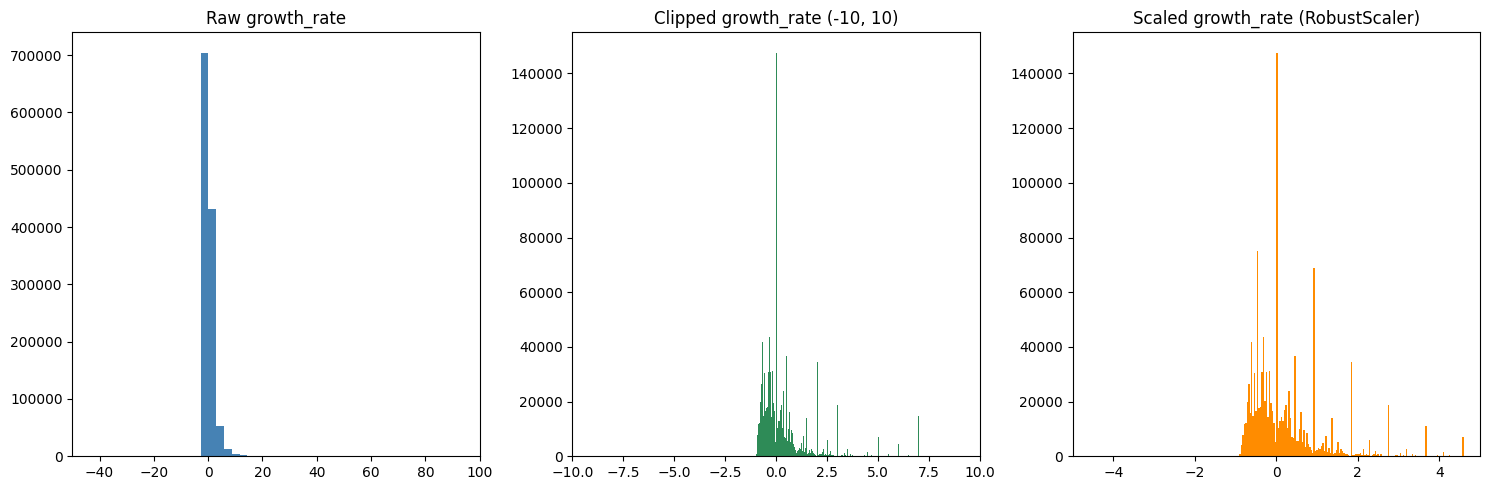

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Raw
axes[0].hist(df["y"], bins=200, color="steelblue", edgecolor="none")
axes[0].set_title("Raw growth_rate")
axes[0].set_xlim(-50, 100)  # zoom in to see bulk

# Clipped
axes[1].hist(df["y_clipped"], bins=200, color="seagreen", edgecolor="none")
axes[1].set_title("Clipped growth_rate (-10, 10)")
axes[1].set_xlim(-10, 10)

# Scaled
axes[2].hist(df["y_scaled"], bins=200, color="darkorange", edgecolor="none")
axes[2].set_title("Scaled growth_rate (RobustScaler)")
axes[2].set_xlim(-5, 5)

plt.tight_layout()
plt.show()


In [35]:
path = Path("../output/data/10_1000866.csv")
#df.query('store_item == "10_638308"')
df.query("store_item == '10_638308'").to_csv(path)

In [40]:
# Your data as a list of lists
data = [
    [39, 43, 4, 9, 14, 10, 14],
    [45, 58, 6, 12, 16, 7, 13],
    [1, 14, 3, 64, 21, 11, 15],
    [51, 49, 5, 11, 2, 0, 0],
    [0, 9, 2, 56, 0, 1, 2]
]

# Column names
columns = [1, 2, 3, 4, 5, 6, 7]

# Row labels
index = [1, 2, 3, 4, 5]

# Create DataFrame
df = pd.DataFrame(data, columns=columns, index=index)
# Set index name and dtype
df.index = df.index.astype("int64")  # ensure dtype
df.index.name = "store"              # set name

# Set columns dtype and name
df.columns = df.columns.astype("int64")  # ensure dtype
df.columns.name = "item"                 # set name
df

item    1   2  3   4   5   6   7
store                           
1      39  43  4   9  14  10  14
2      45  58  6  12  16   7  13
3       1  14  3  64  21  11  15
4      51  49  5  11   2   0   0
5       0   9  2  56   0   1   2

In [41]:

# always coerce to float
X = df.to_numpy(dtype=np.float64)

est = BinaryTriFactorizationEstimator(
    n_row_clusters=9,         # try a few values (e.g., 3–8)
    n_col_clusters=4,
    k_row=None,               # no cap → multi-hard chosen by data
    k_col=None,
    loss="gaussian",
    alpha=1e-2,               # ridge on B for stability
    beta=0.4,                 # >0 makes memberships sparser
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=60,
    tol=1e-5,
    random_state=42,
    verbose=False,
).fit(X)



In [42]:
#assign = est.filter_blocks(X= df.to_numpy(), min_keep=10)
mask   = est.allowed_mask_from_gap(min_keep=5)   # aim for ~5 colors
assign = est.assign_unique_blocks(X= X, method="gaussian_delta",
                                  allowed_mask=mask, on_empty="fallback")
block_id = assign["block_id"]  # (I×J), each cell → one color
df2 = get_normalized_assignments(assign, df)

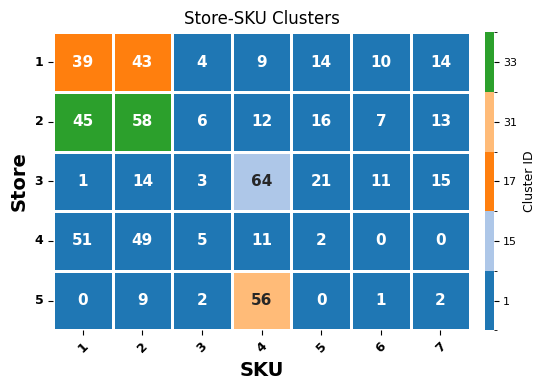

In [43]:
#row_order, col_order = est.get_row_col_orders(assign, df)
#row_order, col_order = est.get_row_col_orders(assign, norm_data2)
df2 = get_normalized_assignments(assign, df)  # contains unique per-cell block_id
#row_order, col_order = get_row_col_orders_smart(df2)
row_order = sorted(df2["store"].unique())
col_order = sorted(df2["item"].unique())

fn = Path("../output/figures/store_item_toy_data_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-SKU Clusters",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    x_label="SKU",
    y_label="Store",
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=None,
    xtick_rotation=45,
)

In [48]:
# Freeze your defaults once, then sweep:
make_btf = BinaryTriFactorizationEstimator.factory(
    k_row=None, 
    k_col=None, 
    loss="gaussian", 
    alpha=1e-2, 
    beta=0.6,
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=50,
    tol=1e-5,
)
    
# Define your grid
R_list = range(1, 10)
C_list = range(1, 10)

# Run the sweep
grid_df = sweep_btf_grid(
    make_btf,
    X,
    R_list,
    C_list,
    restarts=3,
    seeds=range(123, 999),     # optional
    min_keep=6,
    fit_kwargs={"max_iter": 200, "tol": 1e-4},  # pass your estimator kwargs here
)

# Rank and pick the best (edit ranking logic inside pick_best_btf_setting if desired)
ranked_df, best = pick_best_btf_setting(grid_df)


2025-09-08 08:35:13,126 - INFO - Fitting BTF with R=1, C=1
2025-09-08 08:35:13,140 - INFO - Computing cell mask for R=1, C=1
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/BTNMF_util.py:792: RuntimeWarning: Mean of empty slice
  float(np.nanmean(wcvdf["silhouette_like"]))
2025-09-08 08:35:13,145 - INFO - Fitting BTF with R=1, C=2
2025-09-08 08:35:13,165 - INFO - Computing cell mask for R=1, C=2
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/BTNMF_util.py:792: RuntimeWarning: Mean of empty slice
  float(np.nanmean(wcvdf["silhouette_like"]))
2025-09-08 08:35:13,170 - INFO - Fitting BTF with R=1, C=3
2025-09-08 08:35:13,192 - INFO - Computing cell mask for R=1, C=3
2025-09-08 08:35:13,196 - INFO - Fitting BTF with R=1, C=4
2025-09-08 08:35:13,227 - INFO - Computing cell mask for R=1, C=4
2025-09-08 08:35:13,231 - INFO - Fitting BTF with R=1, C=5
2025-09-08 08:35:13,252 - INFO - Computing cell mask for R=1, C=5
2025-

In [49]:
best

n_row                                9.000000
n_col                                4.000000
Mask_Nobs                           11.000000
Mask_Coverage                        0.314286
seed                               123.000000
Loss                               193.697610
Percent_Loss                         0.825334
RMSE                                 2.352492
Percent_RMSE                         9.084789
PVE                                  0.977560
Mean Silhouette                      0.588852
BlockContribution_Total          18626.202594
BlockContribution_PerCell         1693.291145
BlockContribution_RelBaseline        5.808148
BlockContribution_FracWeak20         0.000000
BlockContribution_Gini               0.869474
B_Sparsity                           0.642857
Coverage                             1.000000
AIC                                215.928380
BIC                                230.252610
Name: 0, dtype: float64